In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot'), os.path.join(home, 'astrobot', 'tests')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot import pmf

import numpy as np 
import pandas as pd
from pprint import pprint 
import matplotlib.pyplot as plt 
from functools import reduce 

def pp(x, *args): 
    pprint(x) if not args else (pprint(x), pp(*args))


In [2]:
# bldg_stock namespace
def get_osm_url(bldg_id, zero_pad=7):
    zeros = reduce(
        lambda a, b: str(a)+"0", range(zero_pad - int(np.log10(bldg_id) + 1)))
    return ("https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/" +  "end-use-load-profiles-for-us-building-stock/2021/" +
            "comstock_tmy3_release_1/building_energy_models/" + 
            "bldg{}-up00.osm.gz".format(zeros + str(bldg_id)))
            
DATADIR = "C:/users/admin/master/astrobot/resources/rescomstock/comstock"
assert os.path.isdir(DATADIR)
metacom_fpath = os.path.join(DATADIR, "metadata_comstock.tsv")
_comdf = pd.read_csv(metacom_fpath, sep='\t')
_comdf = _comdf.dropna(axis=0, how="any")
_comdf.head(2)

,bldg_id,applicability,in.upgrade_name,in.aspect_ratio,in.county,in.building_type,in.rotation,in.number_of_stories,in.sqft,in.hvac_system_type,...,out.electricity.total.energy_consumption_intensity,out.site_energy.total.energy_consumption,out.site_energy.total.energy_consumption_intensity,out.natural_gas.total.energy_consumption,out.natural_gas.total.energy_consumption_intensity,out.other_fuel.total.energy_consumption,out.other_fuel.total.energy_consumption_intensity,upgrade,weight,metadata_index
0,105,True,Baseline,2.0,G0100890,SmallOffice,270.0,1.0,17500.0,PSZ-AC with electric coil,...,8.988889,536.748835,0.030671,0.0,0.0,0.0,0.0,0,7.041741,0
1,170,True,Baseline,3.0,G0100690,SmallOffice,270.0,1.0,3000.0,PSZ-AC with electric coil,...,10.487037,107.349767,0.035783,0.0,0.0,0.0,0.0,0,7.041741,1


In [3]:
def search_comdf_var(var):
    return [col for col in _comdf.columns if var.lower() in col.lower()]

#search_comdf_var("weight")
#set(_comdf["in.building_type"])
#_comdf[["metadata_index", "bldg_id"]]
#_comdf.columns

In [4]:
comdf = _comdf.copy()
# pp([c for c in _comdf.columns if "in." in c])

y_lbls = ["eui"] 
X_lbls = ["cz_cat", "cz", "btype_cat", "btype", "weight", "metadata_index", "bldg_id"] 
comdf[["cz_cat", "btype_cat"]] = comdf[["in.climate_zone_ashrae_2004", "in.building_type"]]
_mbtu_arr, _sqft_arr = \
    comdf["out.site_energy.total.energy_consumption"], comdf["in.sqft"]
comdf[y_lbls[0]] = (_mbtu_arr * 1e6 / 3412) / (_sqft_arr / 10.764)  # Convert MBTU, ft2 -> kWh/m2

# Integer encoding for cz categories
cz_dict = {cz:i for i, cz in enumerate(np.unique(comdf["cz_cat"]))}
comdf["cz"] = [cz_dict[cz] for cz in comdf["cz_cat"]]
 
# Integer encoding for btype
btype_dict = {bt:i for i, bt in enumerate(np.unique(comdf["btype_cat"]))}
comdf["btype"] = [btype_dict[bt] for bt in comdf["btype_cat"]]

comdf = comdf[X_lbls + y_lbls]
comdf.head(3)

,cz_cat,cz,btype_cat,btype,weight,metadata_index,bldg_id,eui
0,3A,3,SmallOffice,12,7.041741,0,105,96.760416
1,3A,3,SmallOffice,12,7.041741,1,170,112.887152
2,3A,3,RetailStripmall,9,1.947971,2,254,455.818507


In [73]:

#100 * comdf.query("cz_cat == '7A' | cz_cat == '7B'").weight.sum() / comdf.weight.sum() 

tfpath = os.path.join(DATADIR, "alaska_timeseries_100803-0.parquet")
_tdf = pd.read_parquet(tfpath)
_tdf["idx"] = np.arange(_tdf.shape[0])
_tdf = _tdf.set_index("idx")
pp(_tdf.shape)
pp(_tdf["out.site_energy.total.energy_consumption_intensity"].sum())
__tdf = _tdf[34000:].dropna(axis=1)
pp(__tdf.shape)



(35040, 51)
209.56212137936953
(1040, 35)


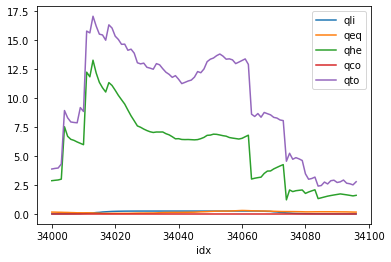

In [100]:
#pp([i for i in _tdf.columns if "intensity" in i])

lbls_old = [
    "timestamp",
    "out.electricity.interior_lighting.energy_consumption_intensity",
    'out.electricity.interior_equipment.energy_consumption_intensity',
    "out.natural_gas.heating.energy_consumption_intensity",
    "out.electricity.cooling.energy_consumption_intensity",
    "out.site_energy.total.energy_consumption_intensity"]
lbls_ = ["qli", "qeq", "qhe", "qco", "qto"]
lbls = ["ti"] + lbls_
tdf = __tdf.rename(columns={a:b for a,b in zip(lbls_old, lbls)}, inplace=False)

i = 34000
(tdf.loc[i:i+96, lbls_] * 1000).plot();

#pp(31 * 24 * 4)
#tdf[lbls].head() * 1000


In [5]:
print(_comdf.shape)
print(_comdf.weight.sum())

from tests.pmf_test import test_make_pmf, test_make_bin_idx, test_make_bin_edges
from tests.pmf_test import test_make_joint_pmf 

from scipy.stats._binned_statistic import binned_statistic
pd.set_option("display.precision", 6)

test_make_bin_edges()
test_make_bin_idx()
test_make_pmf()

test_make_joint_pmf()


(344057, 83)
1543251.4395087715


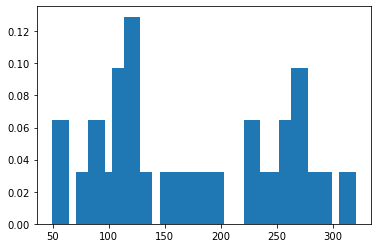

In [24]:
# Joint Pmf
btype = "LargeOffice"
cz = "5B"
data = comdf.query("btype_cat == '{}' & cz_cat == '{}'".format(btype, cz))

eui = pmf.Pmf(data.eui, 25, data.weight, id=data.index)
pmf.plt_hist(eui, width=15); 
eui.df.head(5) 

dfj = pmf.JointPmf([1, 0, 0, 1], [1, 0, 0, 1], bins1=4, bins2=4)




In [8]:
"""
- Goal: Show stairstep?
- Goal: Show forward/inverse prob. models?
- Eval: Show prediction accuracy by testing on validation set. 
"""
theta = "epd"
X = ["cz", "vintage", "btype"]
y = "eui"
evidence = {"eui":[25, 50, 75], "cz":"4B", "vintage":"pst80s", "btype":"LargeOffice"}

# Infer parameter epd from y, X

# Construct data according to Pyro
dag = DAG(data=compdf)  

# Model joint and marginal probability of p(X, eui)
for varx in X: 
    epd_eui_pmf = prob_joint(varx, "eui", dag=dag)
    m1, m2 = prob_marginal(varx, dag=dag), prob_marginal("eui", dag=dag)
    plt_hist3(epd_eui_pmf, m1, m2)
    
# Forward modeling (p(y=[25,50,75]|X,theta)) ??
for x in X: 
    eui_pmf = prob_cond(prior="eui", likelihood=5, marginal=5)

# Model inverse p(X=epd | eui=[25, 50, 75])
for eui_pctile in [25, 50, 75]:
    epd_pmf = prob_cond(prior"epd", likelihood=likelihood, marginal="eui", dag=dag)
    plt_hist(epd_pmf)
    info_metric = cond_entropy(epd_pmf)  # how much info obtained about epd given eui
    print(info_metric)



SyntaxError: invalid syntax (Temp/ipykernel_8960/3668422546.py, line 28)

In [ ]:
# TODO: 
# Xclean up function: _make_joint_pmf(data) 
# Xtest _make_joint_pmf(data)
# XJointPmf(dataset) -> df w/ multiindex
# write: margin_pmf(joint_pmf) -> Pmf
# test p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x)
# plot joint of eui and cz (same as query)
# write cond_pmf
# p(e,cz,v) = p(e|cz,v) p(cz|v) p(v) 


In [ ]:
from scipy.stats import binned_statistic 

# Flip two coins, probability of state = 2^2 = 4 states:
# Joint pmf is:
# [Hx_Hy, Hy_Tx]
# [Tx_Hy, Ty_Tx]
pxy = np.array(
  # y1: H, x2:T
    [[.25, .25],  # x1: H 
     [.25, .25]]) # x2: T
# p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x) 
# Marginalize ith x row by:
# 1. Summing joint through all j cols 
# 2. Normalize with factor p(x_ij) = 1 / sum_ij( p(x_ij, y_ij))    
# p(x_i=1) = sum_j p(x_i=1, y_j) 
#px = 1 / np.sum([xy_ij for x_i in pxy for xy_ij in x_i])
px_i = np.array([[np.sum(x_i)] for x_i in pxy])
# pp(px_i)
# For py iterate through column space
py_i = np.array([[np.sum(y_j)] for y_j in pxy.T]).T
# pp(py_i)
